In [4]:
pip install statsmodels

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [6]:
path="/content/drive/MyDrive/Colab Notebooks/energy.csv"
df=pd.read_csv(path)
df

,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00
...,...,...,...
26299,2014-12-31 19:00:00,"4,012.00",18.00
26300,2014-12-31 20:00:00,"3,856.00",16.67
26301,2014-12-31 21:00:00,"3,671.00",17.00
26302,2014-12-31 22:00:00,"3,499.00",15.33


In [7]:
df.head(10)

,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00
5,2012-01-01 05:00:00,"2,453.00",31.33
6,2012-01-01 06:00:00,"2,560.00",30.00
7,2012-01-01 07:00:00,"2,719.00",29.00
8,2012-01-01 08:00:00,"2,916.00",29.00
9,2012-01-01 09:00:00,"3,105.00",33.33


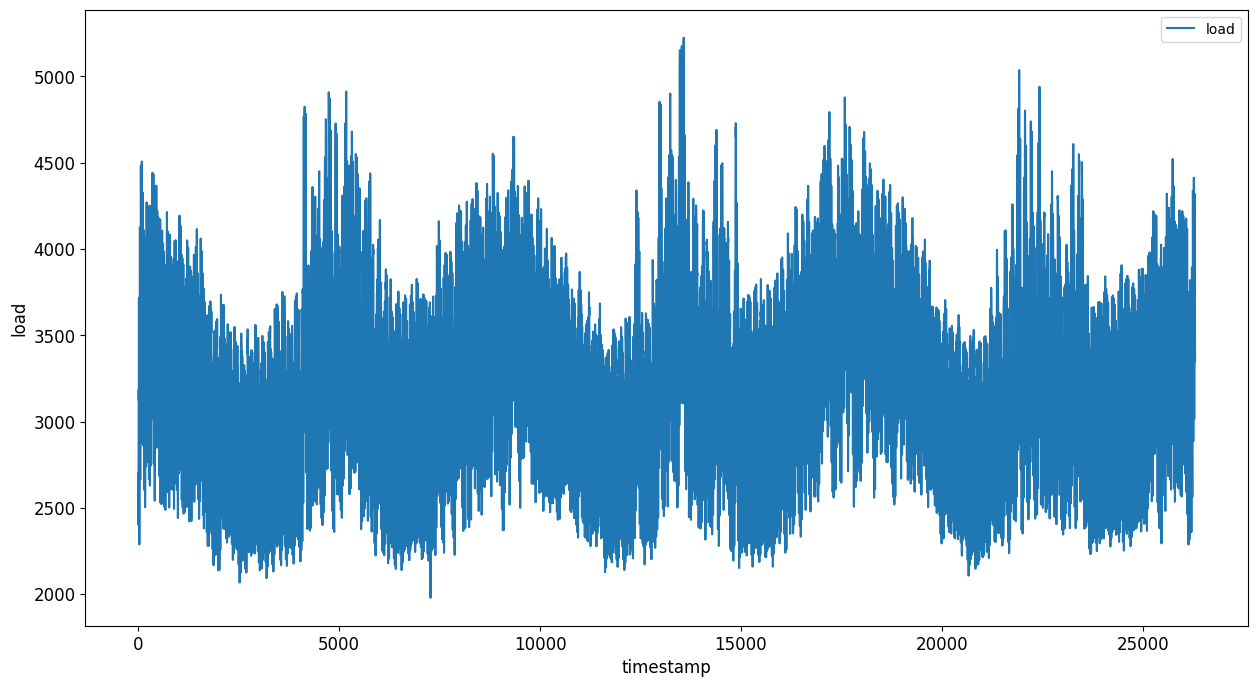

In [8]:
df.plot(y="load",subplots=True,figsize=(15,8),fontsize=12)
plt.xlabel("timestamp",fontsize=12)
plt.ylabel("load",fontsize=12)
plt.show()

In [9]:
df.isnull().sum()

,0
timestamp,0
load,0
temp,0


In [10]:
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp')

In [11]:
train_start_dt=pd.to_datetime('2014-11-01 00:00:00')
test_start_dt=pd.to_datetime('2014-12-30 00:00:00')

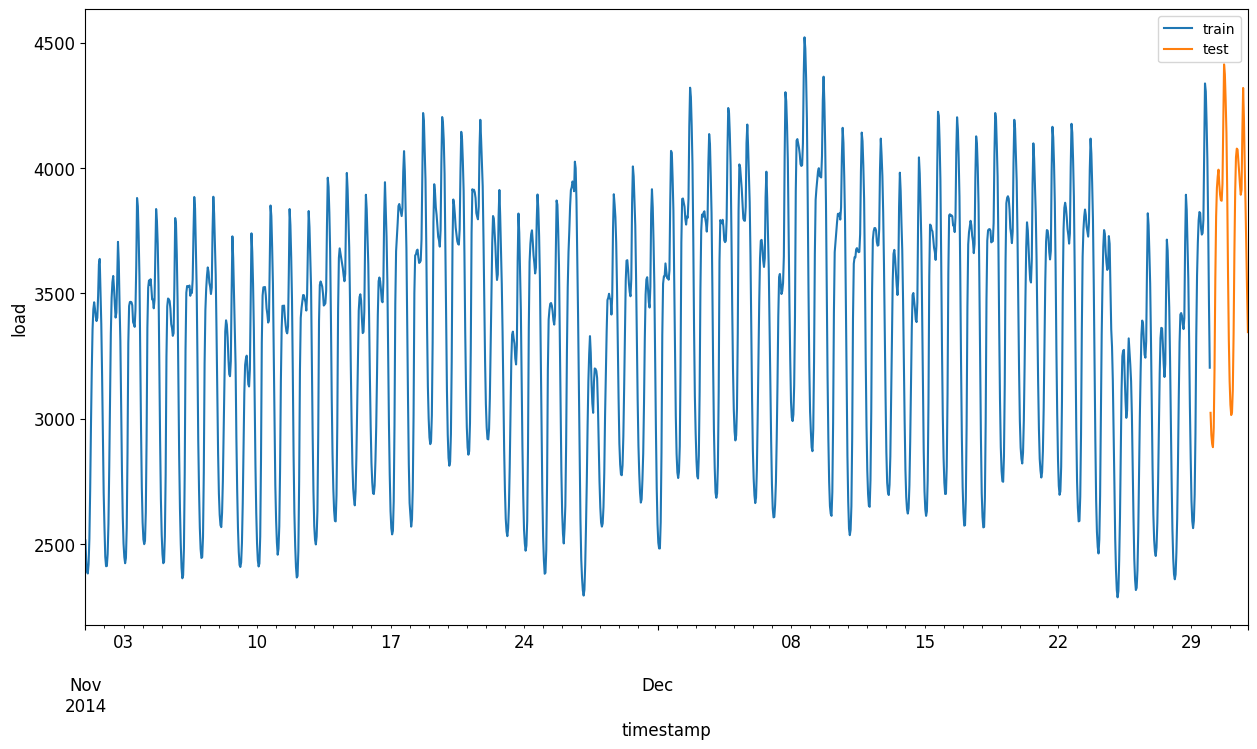

In [12]:
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(df[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [13]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['load']]
test = df.copy()[df.index >= test_start_dt][['load']]
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [14]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
timestamp,
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40


In [15]:
test['load'] = scaler.transform(test)
test.head()

,load
timestamp,
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [24]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [25]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.235
Date:                            Sun, 19 Jan 2025   AIC                          -6942.469
Time:                                    16:00:26   BIC                          -6911.042
Sample:                                11-01-2014   HQIC                         -6930.717
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8397      0.016     52.251      0.000       0.808       0.871
ar.L2         -0.5209      0.034   

In [26]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
timestamp,,,,
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68


In [27]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.73097582811101

In [31]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.repeat(test_ts['load'].values, HORIZON)[:len(eval_df)]
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,008.79","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,955.55","3,023.00"
2,2014-12-30 02:00:00,t+1,"2,900.21","3,023.00"
3,2014-12-30 03:00:00,t+1,"2,917.59","2,935.00"
4,2014-12-30 04:00:00,t+1,"2,946.37","2,935.00"


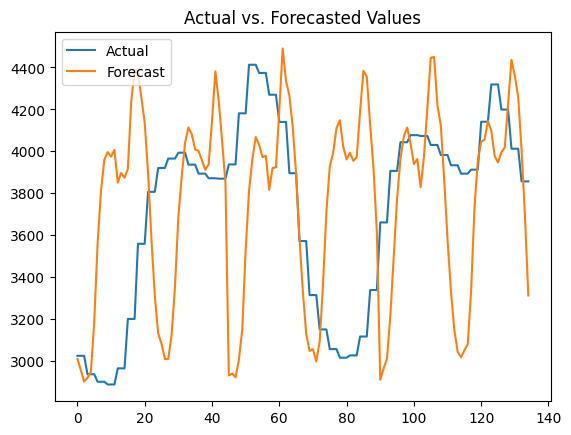

In [33]:
actual=eval_df['actual']
prediction=eval_df['prediction']
plt.plot(actual, label='Actual')
plt.plot(prediction, label='Forecast')
plt.legend()
plt.title('Actual vs. Forecasted Values')
plt.show()

In [36]:
import gzip, pickle, pickletools
filepath = "/content/model.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(model)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)
